In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

# strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
strategy = tf.distribute.OneDeviceStrategy("GPU:0")
print(strategy)


import autoenc_model as aem
import data_generator as dg
import utils

/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
noise_filter = True

In [39]:
# Read images
# data_files = glob.glob("data/composite_data/2016*.npy")
data_files = glob.glob("data/composite_data_polar/2016*.npy")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    noise_imgs = [x.split("/")[-1].replace(".fits", ".npy") for x in noise_imgs]

    data_files = [f for f in data_files if f.split("/")[-1] not in noise_imgs]

data_matrix = np.empty([len(data_files),100,360,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    if data_point.shape[0] == 100:
        data_matrix[idx] = data_point
    else:
        print(data_point.shape, data_file)

data_matrix[:,:,:,0] = np.clip(data_matrix[:,:,:,0], 0, 5000)
data_matrix[:,:,:,1] = np.clip(data_matrix[:,:,:,1], 0, 3000)
data_matrix[:,:,:,2] = np.clip(data_matrix[:,:,:,2], -400, 400)

min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

rg = max_values - min_values
rg = np.fmax(rg, 1e-4)

data_matrix_norm = 2*((data_matrix - min_values)/rg) - 1

# Normalize HMI magnetogram data differently
hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)

data_matrix_norm[:,:,:,2] = data_matrix[:,:,:,2] / hmi_max_values

data_matrix_norm[np.isnan(data_matrix_norm)] = 0

# data_matrix_norm = (data_matrix_norm*2)-1

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

/tmp/ipykernel_4364/3736883557.py:29: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_4364/3736883557.py:30: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_4364/3736883557.py:38: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


(-1.0, 1.0)

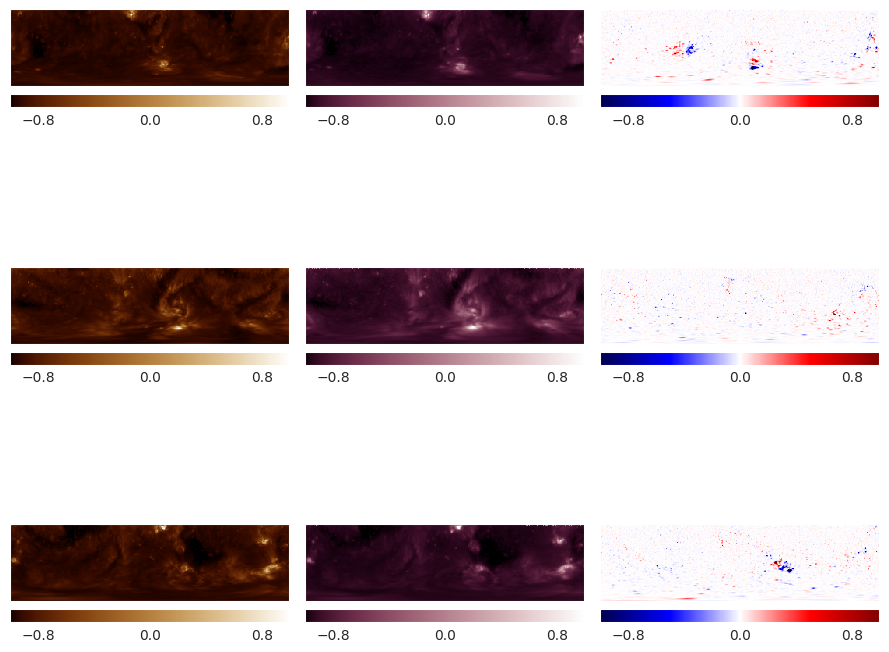

In [40]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=-1, vmax=1)

(200, 200) (100, 360)


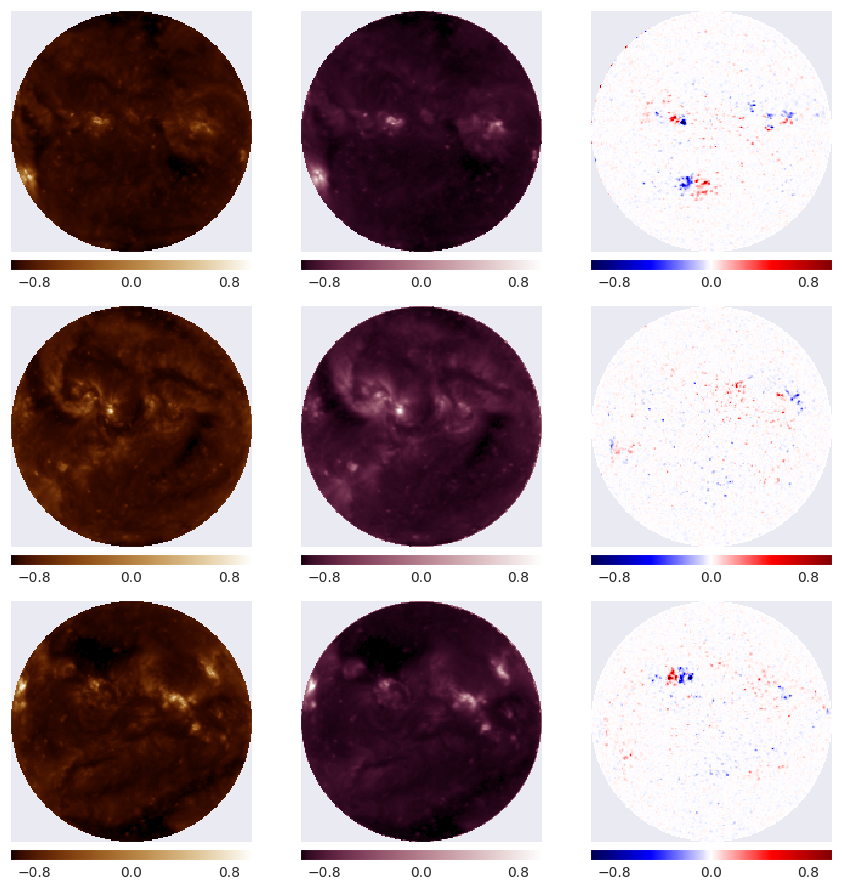

In [41]:
p2l_none = lambda x: utils.polar_to_linear(x, cval=np.nan)
print(utils.polar_to_linear(image_list[0]).shape, image_list[0].shape)
ax = isns.ImageGrid(image_list.copy(), col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, map_func=p2l_none, orientation="h", vmin=-1, vmax=1)

In [44]:
latent_size = 128
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

autoencoder, encoder, decoder = aem.gen_xception_autoenc_polar_3c(latent_size, optim=optimizer, loss=loss_fn)

Number of devices: 1
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 cylindrical_padding2d_2 (Cylin  (None, 100, 366, 3)  0          ['input_5[0][0]']                
 dricalPadding2D)                                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 49, 182, 32)  864         ['cylindrical_padding2d_2[0][0]']
                                                                       

In [45]:
n_epochs = 100
batch_size = 30

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/100
56/56 [==============================] - 9s 111ms/step - loss: 0.4795 - mae: 0.5650 - val_loss: 0.4074 - val_mae: 0.5217
Epoch 2/100
56/56 [==============================] - 5s 96ms/step - loss: 0.3325 - mae: 0.4700 - val_loss: 0.2542 - val_mae: 0.4121
Epoch 3/100
56/56 [==============================] - 5s 96ms/step - loss: 0.0445 - mae: 0.1295 - val_loss: 0.0124 - val_mae: 0.0530
Epoch 4/100
56/56 [==============================] - 5s 95ms/step - loss: 0.0129 - mae: 0.0600 - val_loss: 0.0131 - val_mae: 0.0553
Epoch 5/100
56/56 [==============================] - 5s 96ms/step - loss: 0.0119 - mae: 0.0565 - val_loss: 0.0116 - val_mae: 0.0495
Epoch 6/100
56/56 [==============================] - 5s 95ms/step - loss: 0.0115 - mae: 0.0551 - val_loss: 0.0155 - val_mae: 0.0677
Epoch 7/100
56/56 [==============================] - 6s 101ms/step - loss: 0.0111 - mae: 0.0539 - val_loss: 0.0112 - val_mae: 0.0492
Epoch 8/100
56/56 [==============================] - 6s 107ms/step - loss:

20/20 [==============================] - 1s 32ms/step - loss: 0.0054 - mae: 0.0341


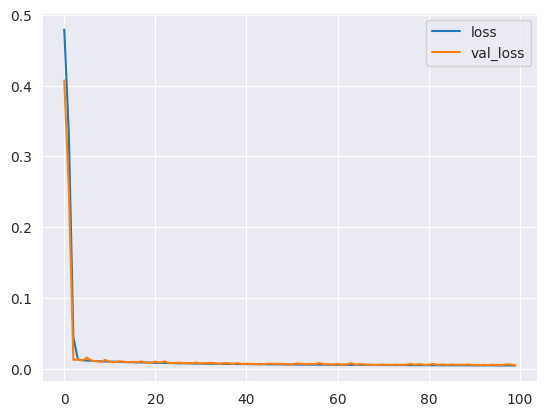

In [46]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 100, 360, 3)


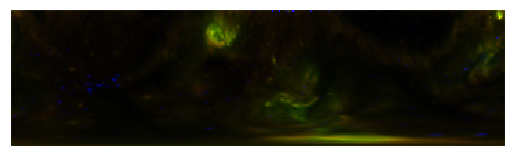

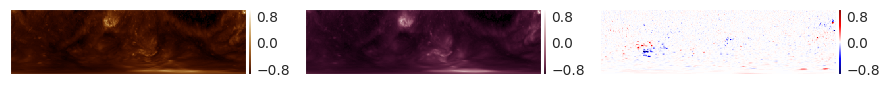

In [47]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)

test_img_display = test_img[0].copy()
test_img_display[:,:,0] = np.abs((test_img_display[:,:,0] + 1)/2)
test_img_display[:,:,1] = np.abs((test_img_display[:,:,1] + 1)/2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=-1, vmax=1)

<AxesSubplot: >

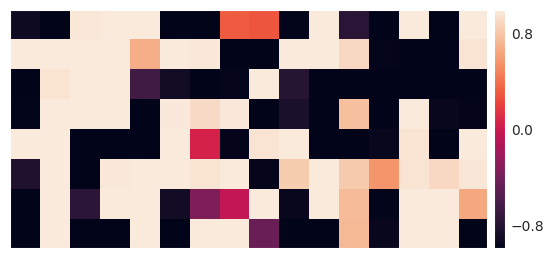

In [48]:
code = encoder(test_img)

isns.imgplot(utils.square_dims_vector(np.asarray(code)), vmin=-1, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


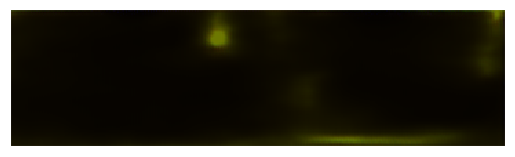

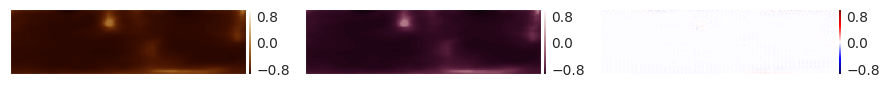

In [49]:
decoded = decoder(code)
# isns.imgplot(decoded[0])
decoded_display = np.copy(decoded)[0]
decoded_display[:,:,0] = np.abs((decoded_display[:,:,0] + 1)/2)
decoded_display[:,:,1] = np.abs((decoded_display[:,:,1] + 1)/2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=-1, vmax=1)

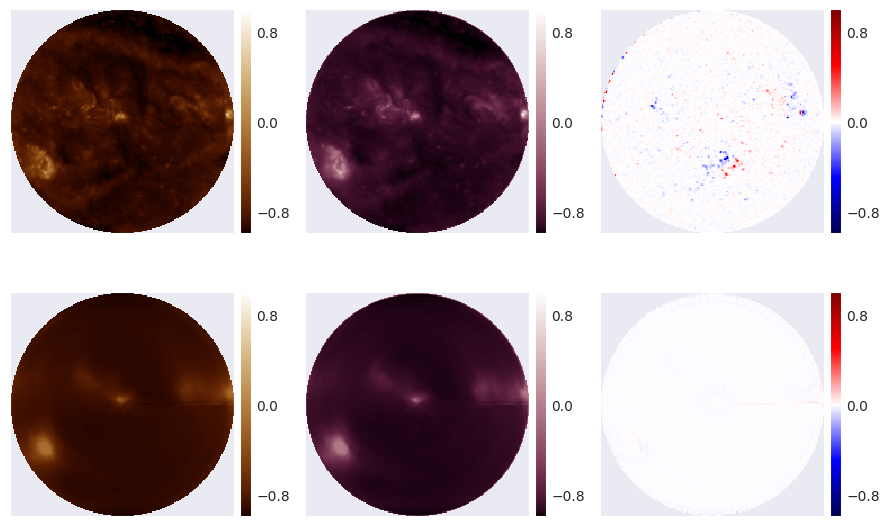

In [50]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=-1, vmax=1, map_func=p2l_none)

In [51]:
fine_tunner_optimizer = keras.optimizers.RMSprop(learning_rate=1e-5)

def mse_weighted(y_real, y_pred):
    diff = (y_real - y_pred)**2
    weights = tf.ones_like(diff) * tf.constant([0.3,0.3,1.0])

    return keras.backend.mean(weights*diff**2)


autoencoder.compile(optimizer=fine_tunner_optimizer, loss=mse_weighted)
history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/100


2023-04-22 15:56:44.401725: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 66355200 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 35389440/10494541824
2023-04-22 15:56:44.401754: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      7858880512
InUse:                      4733438604
MaxInUse:                   5789240524
NumAllocs:                    27686362
MaxAllocSize:               1202022696
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-04-22 15:56:44.401810: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-04-22 15:56:44.401815: E tensorflow/compiler/xla/stream_executo

ResourceExhaustedError: Graph execution error:

Detected at node 'model_8/model_6/separable_conv2d_70/separable_conv2d' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/usr/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4364/2503262387.py", line 11, in <module>
      history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/eugeniolr/.local/lib/python3.10/site-packages/keras/layers/convolutional/separable_conv2d.py", line 188, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'model_8/model_6/separable_conv2d_70/separable_conv2d'
OOM when allocating tensor with shape[30,256,24,90] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node model_8/model_6/separable_conv2d_70/separable_conv2d}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_152527]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 100, 360, 3)


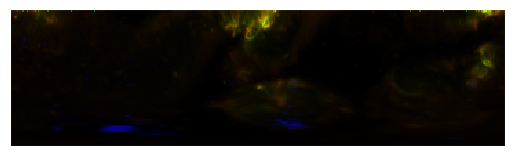

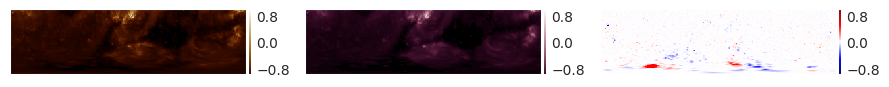

In [ ]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)

test_img_display = test_img[0].copy()
test_img_display[:,:,0] = np.abs((test_img_display[:,:,0] + 1)/2)
test_img_display[:,:,1] = np.abs((test_img_display[:,:,1] + 1)/2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=-1, vmax=1)

<AxesSubplot: >

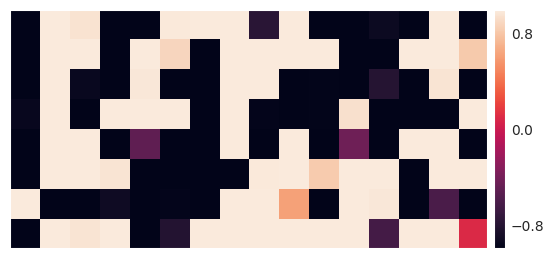

In [ ]:
code = encoder(test_img)

isns.imgplot(utils.square_dims_vector(np.asarray(code)), vmin=-1, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


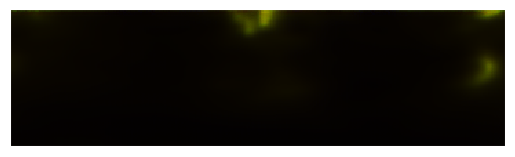

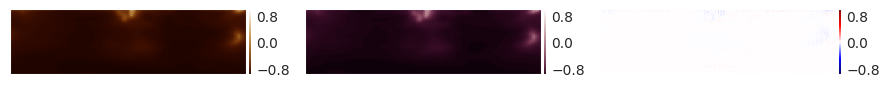

In [ ]:
decoded = decoder(code)
# isns.imgplot(decoded[0])
decoded_display = np.copy(decoded)[0]
decoded_display[:,:,0] = np.abs((decoded_display[:,:,0] + 1)/2)
decoded_display[:,:,1] = np.abs((decoded_display[:,:,1] + 1)/2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=-1, vmax=1)

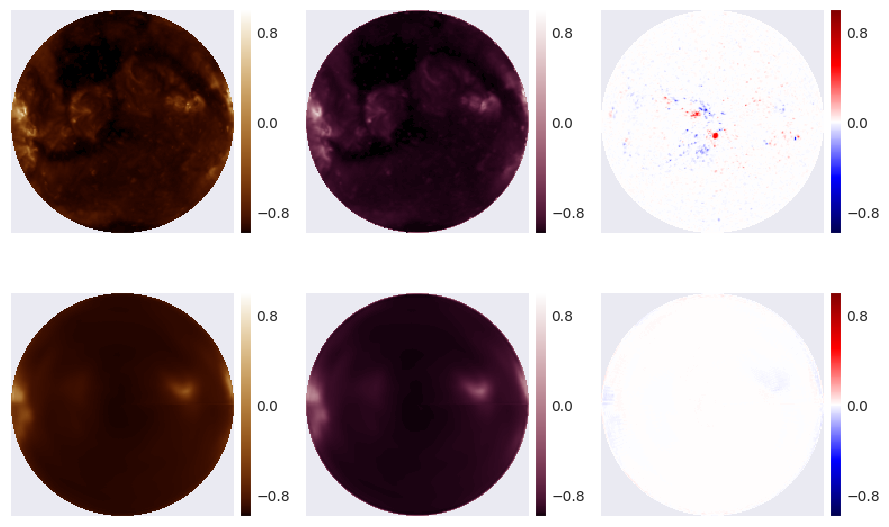

In [ ]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=-1, vmax=1, map_func=p2l_none)